## Imports

In [31]:
# Data handling
import numpy as np
import pandas as pd

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

## Reading the training dataset (`train.csv`)

In [32]:
# Contents of the data directory (similar to Kaggle)
!ls ../data

sample_submission.csv
test.csv
train.csv


In [33]:
# Reading the dataset
df = pd.read_csv('../data/train.csv')

## Initial lookup

In [34]:
# Initial lookup
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [36]:
df.describe(percentiles=[.99, .75, .5, .33, .25, .1])

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
33%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
99%,65.000000,3096.230000,8033.310000,2333.440000,5390.100000,5646.680000


## Variable Identification

In this stage our goal is to determine the _"types"_ of variables.

In [83]:
print('COLUMN', 'TYPE'.rjust(24, ' '))
print('~'*31)
for c in df.columns:
    t = 'Continuous' if df[c].nunique() > 10 else 'Categorical'
    print(c, t.rjust(30 - len(c), '-'))

COLUMN                     TYPE
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PassengerId --------Categorical
HomePlanet ---------Categorical
CryoSleep ----------Categorical
Cabin ---------------Continuous
Destination --------Categorical
Age -----------------Continuous
VIP ----------------Categorical
RoomService ---------Continuous
FoodCourt -----------Continuous
ShoppingMall --------Continuous
Spa -----------------Continuous
VRDeck --------------Continuous
Name ----------------Continuous
Transported --------Categorical
GroupId -------------Continuous
Deck ---------------Categorical
Num -----------------Continuous
Side ---------------Categorical


## Exploratory Data Analysis

### Univariate Analysis

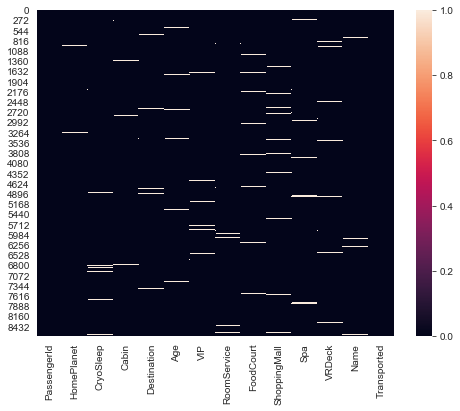

In [37]:
# Visualizing the nulls
plt.figure(figsize=(8,6))
sns.heatmap(pd.isna(df))
plt.show()

#### `PassengerId`

A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [38]:
# Looking at individual columns
df.PassengerId
# This takes the form of gggg_pp,
# where gggg indicates a group the passenger is travelling with and `pp` is their
# number within the group.

0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object

Creating attribute `GroupId` and `PassengerId`

In [39]:
# FEATURE ENGINEERING
# Splitting PassengerId into GroupID and PassengerId

df['GroupId'] = df.PassengerId.apply(lambda x: x.split('_')[0])
df['PassengerId'] = df.PassengerId.apply(lambda x: x.split('_')[1])

#### `HomePlanet`
The planet the passenger departed from, typically their planet of permanent residence.

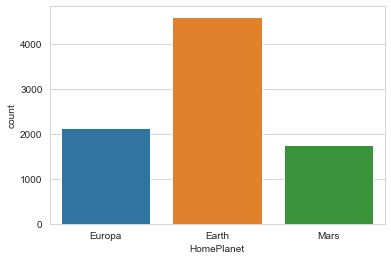

In [40]:
sns.countplot(df.HomePlanet)
plt.show()

#### `CryoSleep`
Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

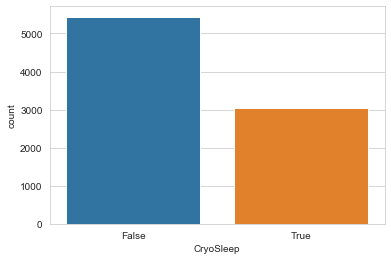

In [41]:
sns.countplot(df.CryoSleep)
plt.show()

#### `Cabin`
The cabin number where the passenger is staying. Takes the form `deck/num/side`, where side can be either `P` for Port or `S` for Starboard.

In [42]:
# Breaking Cabin into deck, num and side
decks, nums, sides = [], [], []
lists = [decks, nums, sides]
for _, row in df.iterrows():
    if pd.isna(row.Cabin):
        for l in lists:
            l.append(np.nan)
    else:
        x = row.Cabin.split('/')
        for i, l in enumerate(lists):
            l.append(x[i])

df['Deck'] = decks
df['Num'] = nums
df['Side'] = sides

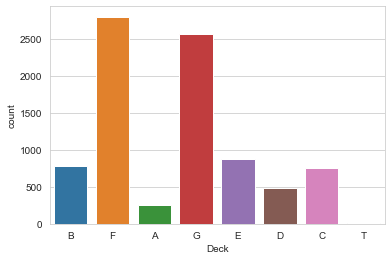

In [43]:
sns.countplot(df.Deck)
plt.show()

#### `Num`
Number of occupants of the cabin

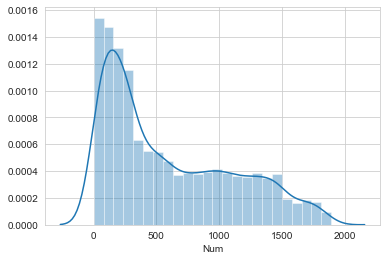

In [44]:
sns.distplot(df.Num)
plt.show()

#### `Side`
At which side of the ship the cabin was located.
* `P` implies **Port**
* `S` implies **Starboard**

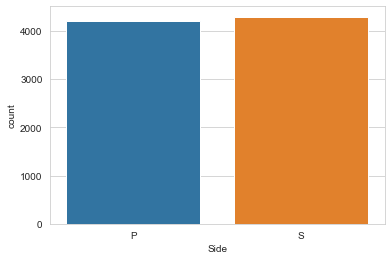

In [45]:
sns.countplot(df.Side)
plt.show()

#### `Destination`
The planet the passenger will be debarking to.

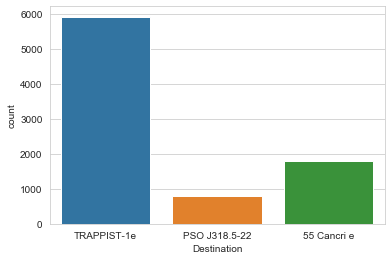

In [46]:
sns.countplot(df.Destination)
plt.show()

#### `Age`
The age of the passenger.

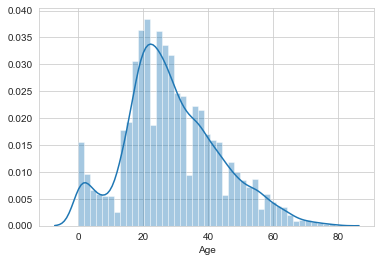

In [47]:
sns.distplot(df.Age)
plt.show()

#### `VIP`
Whether the passenger has paid for special VIP service during the voyage.

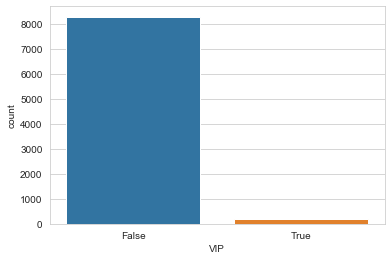

In [48]:
sns.countplot(df.VIP)
plt.show()

#### `RoomService`

Amount the passenger has billed at the room service.

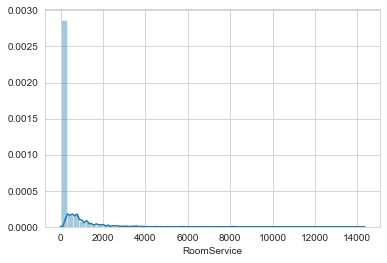

In [49]:
sns.distplot(df.RoomService)
plt.show()

#### `FoodCourt`
Amount the passenger has billed at the food court.

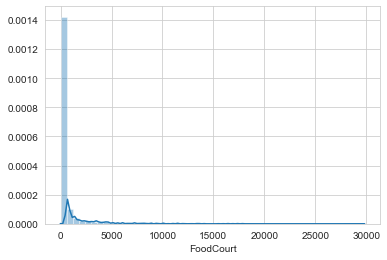

In [50]:
sns.distplot(df.FoodCourt)
plt.show()

#### `ShoppingMall`
Amount the passenger has billed at the shopping mall.

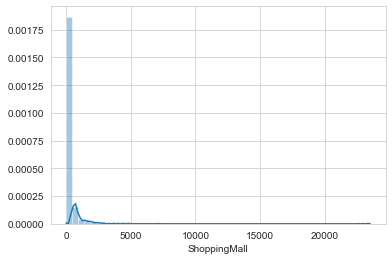

In [51]:
sns.distplot(df.ShoppingMall)
plt.show()

#### `Spa`
Amount the passenger has billed at the spa.

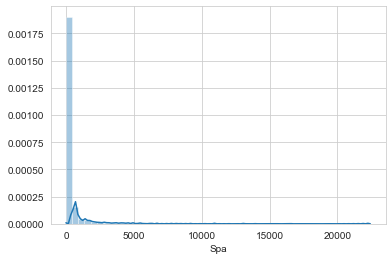

In [52]:
sns.distplot(df.Spa)
plt.show()

#### `VRDeck`
Amount the passenger has billed at the VR deck.

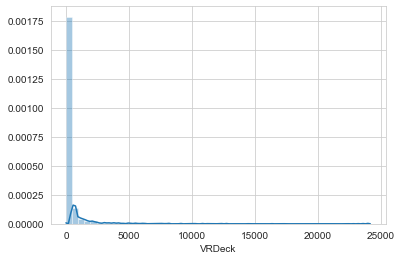

In [53]:
sns.distplot(df.VRDeck)
plt.show()

#### `Transported`
Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

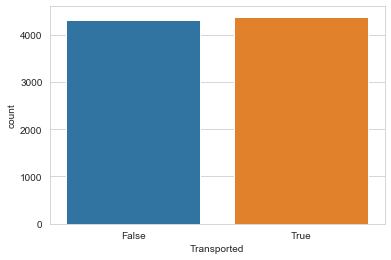

In [54]:
sns.countplot(df.Transported)
plt.show()